In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bayesian_optimization import jit_plus_server, plot_example_gpr

In [2]:
np.random.seed(17)
jit_plus_server([0.5])

1.5607447789648075

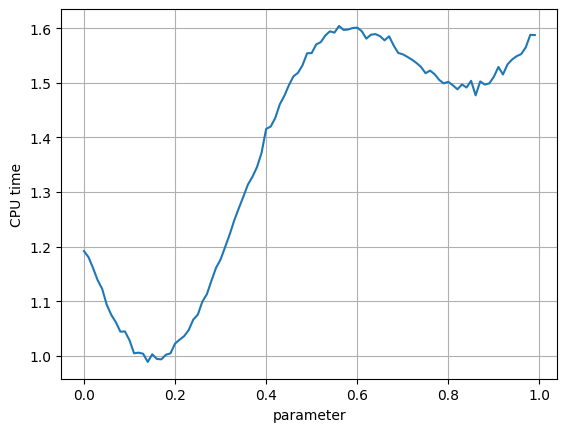

In [3]:
x = np.arange(0, 1, 0.01)
y = [jit_plus_server([i]) for i in x]
plt.plot(x, y)
plt.grid()
plt.xlabel("parameter")
plt.ylabel("CPU time");

In [4]:
np.random.seed(17)
parameter = 0
cpu_time = jit_plus_server([parameter])
cpu_time

1.2025010344211848

In [5]:
class GPR1:
    def __init__(self, parameters, measurements, sigma=None):
        self.x = parameters
        self.y = np.array(measurements)
        self.mean_y = self.y.mean()

    def estimate(self, query_parameter):
        return self.mean_y

In [6]:
class GPR2:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma
        self.mean_y = self.y.mean()
        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        weights = [self.kernel(x, query_parameter) for x in self.x]
        weights = np.array(weights)
        weights = weights / weights.sum()
        return self.mean_y + weights @ self.y

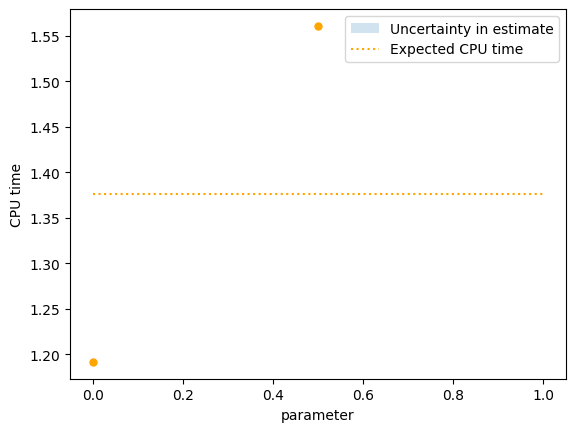

In [12]:
np.random.seed(17)
parameters = [0.5, 0.0]
cpu_time = [jit_plus_server([p]) for p in parameters]


ax = plt.gca()
plot_example_gpr(GPR1, ax, parameters, cpu_time, err_bars=True)
plt.xlabel("parameter")
plt.ylabel("CPU time");

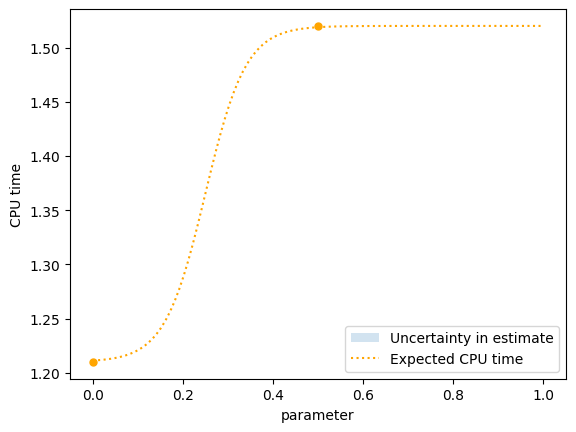

In [13]:
np.random.seed(17)
parameters = [0.5, 0.0]
cpu_time = [1.52, 1.21]

ax = plt.gca()
plot_example_gpr(GPR2, ax, parameters, cpu_time, err_bars=True)
plt.xlabel("parameter")
plt.ylabel("CPU time");

In [14]:
class GPR3:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        kernels_x_query = np.array([self.kernel(x, query_parameter) for x in self.x])
        kernels_x_x = np.array(
            [[self.kernel(x1, x2) for x1 in self.x] for x2 in self.x]
        )
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)
        return self.mean_y + weights @ self.y

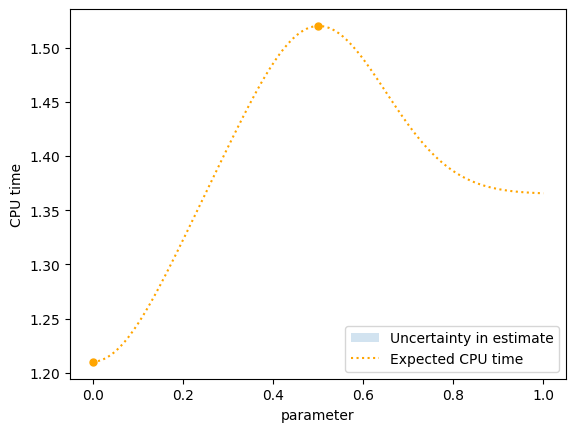

In [15]:
np.random.seed(17)
parameters = [0.5, 0.0]
cpu_time = [1.52, 1.21]

ax = plt.gca()
plot_example_gpr(GPR3, ax, parameters, cpu_time, err_bars=True)
plt.xlabel("parameter")
plt.ylabel("CPU time");

In [16]:
class GPR4:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        if len(self.y) > 1:
            self.std_y = self.y.std()
        else:
            self.std_y = 1

        self.y -= self.mean_y

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp(-distance_squared / (2 * self.sigma**2))

    def estimate(self, query_parameter):
        kernels_x_query = np.array([self.kernel(x, query_parameter) for x in self.x])
        kernels_x_x = np.array(
            [[self.kernel(x1, x2) for x1 in self.x] for x2 in self.x]
        )

        weights = kernels_x_query.T @ np.linalg.pinv(kernels_x_x)
        expectation = self.mean_y + weights @ self.y
        uncertainty_squared = 1 - weights @ kernels_x_query
        return expectation, self.std_y * np.sqrt(np.maximum(0, uncertainty_squared))

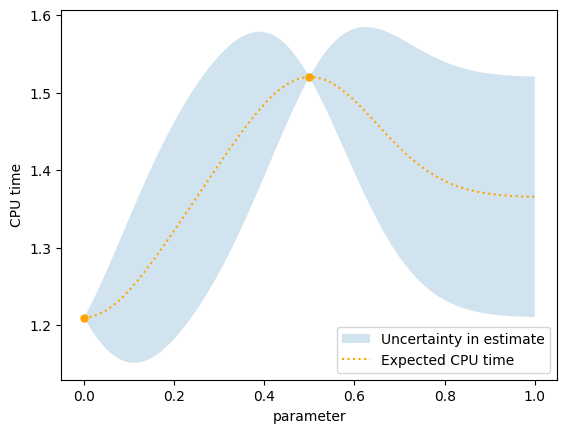

In [17]:
np.random.seed(17)
parameters = [0.5, 0.0]
cpu_time = [1.52, 1.21]

ax = plt.gca()
plot_example_gpr(GPR4, ax, parameters, cpu_time, err_bars=True)
plt.xlabel("parameter")
plt.ylabel("CPU time");

## Minimize the acquisition function

k=1, x=[0.11111111] y=[1.15152763]
k=2, x=[0.16161616] y=[1.03432056]
k=3, x=[1.] y=[0.90060502]


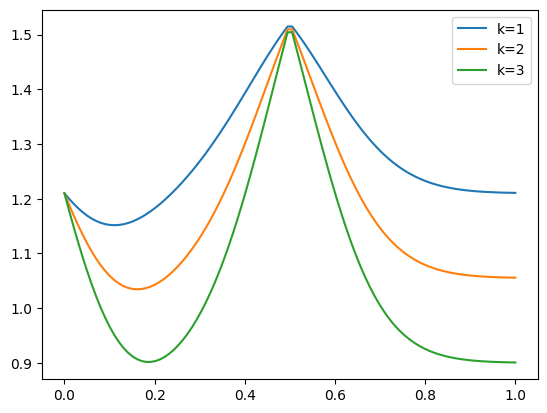

In [35]:
parameters = np.array([0.5, 0.0])
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 100)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
k = 1


def lcb(x_hats, k):
    y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
    lcb = np.array(y_hats) - k * np.array(sigma_y_hats)
    plt.plot(x_hats, lcb, label=f"k={k}")
    i = np.where(lcb == lcb.min())
    print(f"k={k}, x={x_hats[i]} y={lcb[i]}")


lcb(x_hats, 1)
lcb(x_hats, 2)
lcb(x_hats, 3)
plt.legend();

## Optimize all seven compiler parameters

In [36]:
def evaluate(gpr, x):
    x = np.mod(x, 1)
    y, sigma_y = gpr.estimate(x)
    lcb = y - sigma_y
    return x, lcb


def random_search(gpr, num_parameters, num_iterations=1000):
    step_size = 0.1
    x_current = np.random.normal(size=num_parameters)
    x_current, lcb_current = evaluate(gpr, x_current)
    for _ in range(num_iterations):
        x_test = x_current + step_size * np.random.normal(size=num_parameters)
        x_test, lcb_test = evaluate(gpr, x_test)
        if lcb_test < lcb_current:
            lcb_current = lcb_test
            x_current = x_test
    return x_current

In [42]:
np.random.seed(17)
parameters = [np.array([0.5]), np.array([0.0])]
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
random_search(gpr4, num_parameters=1)

array([0.11096591])

In [49]:
class BayesianOptimizer:
    def __init__(self, num_parameters):
        self.num_parameters = num_parameters
        self.parameters = []
        self.measurements = []
        self.x0 = np.array([0.5] * num_parameters)

    def ask(self):
        if len(self.measurements) == 0:
            return self.x0
        return self.new_parameter()

    def new_parameter(self):
        gpr = GPR4(self.parameters, self.measurements, sigma=0.15)
        return random_search(gpr, self.num_parameters, num_iterations=500)

    def tell(self, parameter, measurement):
        self.parameters.append(parameter)
        self.measurements.append(measurement)

In [50]:
np.random.seed(7)
bo = BayesianOptimizer(num_parameters=7)
for _ in range(48):
    parameter = bo.ask()
    cpu_time = jit_plus_server(parameter)
    bo.tell(parameter, cpu_time)

Text(0, 0.5, 'measured CPU time')

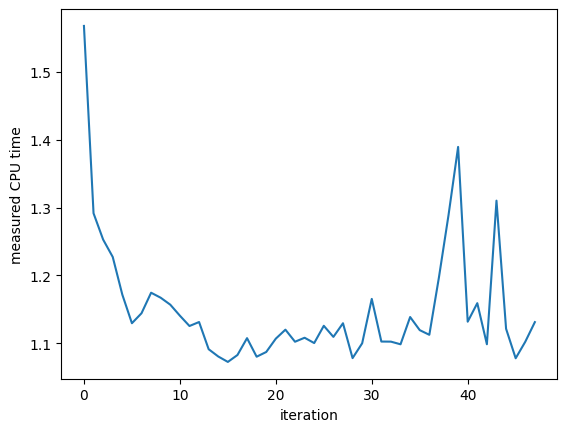

In [52]:
plt.plot(bo.measurements)
plt.xlabel("iteration")
plt.ylabel("measured CPU time")